In [1]:
import os
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Check which platform is running the notebook
if platform.system() == 'Windows':
    PROJECT_PATH = "\\".join(os.getcwd().split('\\')[:-1])
else:
    # Assuming a Unix based platform
    PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

# Load the training dataset
house_prices_train = pd.read_csv(TRAIN_DATA_PATH)
house_prices_train = house_prices_train.drop('Id', axis=1)
house_prices_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Creating a training and testing set from the data

In [2]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
test_size = 0.3
target_feature = 'SalePrice'

X = house_prices_train.drop(target_feature, axis=1)
y = house_prices_train[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=test_size)

In [3]:
print('Training size: ', X_train.shape)
print('Testing size: ', X_test.shape)

Training size:  (1022, 79)
Testing size:  (438, 79)


## Processing the data

### Removing features with missing values

In [4]:
def remove_missing_features(X, threshold=0.8, verbose=False):
    features = X.columns
    features_to_remove = []
    dataset_size = X.shape[0]
    for f in features:
        missing_count = X[X[f].isna()].shape[0]
        missing_ratio = missing_count / dataset_size
        if missing_ratio > threshold:
            features_to_remove.append(f) 
            if verbose:
                print("{:14}{:.3f}%".format(f, missing_ratio * 100))
    return X.drop(features_to_remove, axis=1)

# Extract a dataset with null features removed
X_train_df = remove_missing_features(X_train, verbose=True)

Alley         93.542%
PoolQC        99.511%
Fence         80.235%
MiscFeature   96.086%


### Removing features with a single value

Removing features that all have the same value

In [5]:
def remove_single_values(X, verbose=False):
    features = X.columns
    features_to_remove = []
    for f in features:
        value_count = X[f].nunique()
        if value_count == 1:
            features_to_remove.append(f)
            if verbose:
                print('Removing ', f)
    return X.drop(features_to_remove, axis=1)

X_train_df = remove_single_values(X_train_df)

### Removing Correlated Features

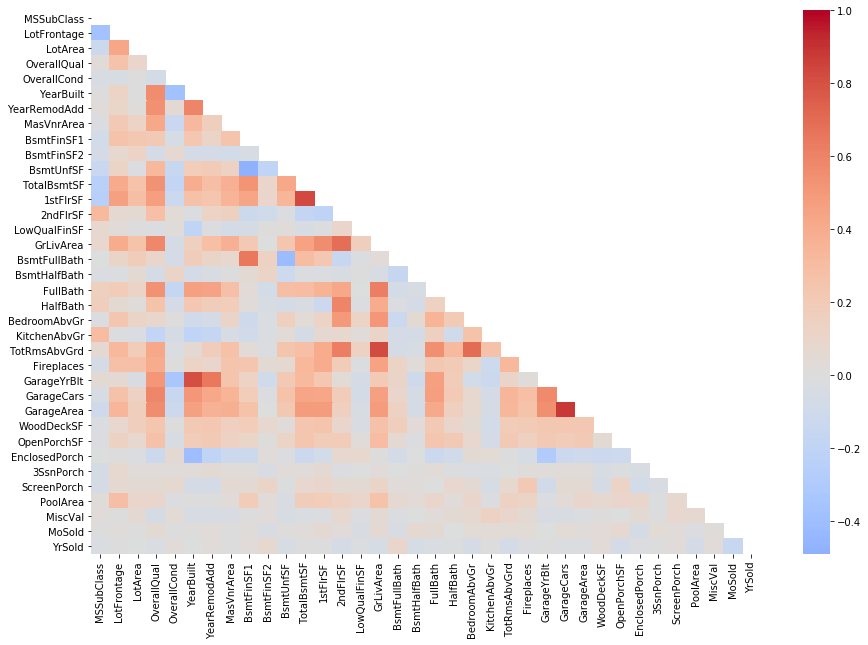

In [6]:
def plot_correlation_triangle(X):
    corr = X.corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, mask=mask, center=0, cmap= 'coolwarm')
    plt.show()

# Plot the heatmap first to see what the correlations are like
plot_correlation_triangle(X_train_df)

In [7]:
def remove_highly_correlate_features(X, threshold=0.9):
    corr = X.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_remove = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_remove, axis=1)

X_train_df = remove_highly_correlate_features(X_train_df)

## Impute missing values

In [8]:
def features_with_missing_values(X):
    features = X.columns
    dataset_size = X.shape[0]
    to_impute = []
    for f in features:
        feature_count = X[X[f].isna()].shape[0]
        if (feature_count != dataset_size) and (feature_count != 0):
            to_impute.append(f)
    return to_impute

numeric_features_to_impute = features_with_missing_values(X_train_df)
numeric_features_to_impute

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

Creating a basic impute pipeline where categorical values will have the most frequent value and numeric values will have the median.

This pipeline will also process the data by applying a log transformation

### Processing Pipeline

In [9]:
from sklearn.base import TransformerMixin

class SparseToDense(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.todense()

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

numeric_cols = X_train_df.select_dtypes(['float64', 'int64']).columns.tolist()
cateorical_cols = X_train_df.select_dtypes(['object']).columns.tolist()

numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p))
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

processing_pipeline = Pipeline([
    ('process', ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_cols),
        ('categorical', categorical_pipeline, cateorical_cols),
    ])),
    ('dense', SparseToDense())
])

In [11]:
X_train_processed = processing_pipeline.fit_transform(X_train)
X_train_processed.shape

(1022, 270)

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression

# Get the best 50 features
k_best = SelectKBest(score_func=f_regression, k=50)
X_train_k_best = k_best.fit_transform(X_train_processed, y_train)
X_train_k_best.shape

(1022, 50)

In [13]:
processed_cateogires_features = np.concatenate(
    processing_pipeline['process'].transformers_[1][1]['one_hot'].categories_
)

processed_columns = np.asarray(numeric_cols + processed_cateogires_features.tolist())

In [15]:
feature_indices = np.where(k_best.get_support())[0].tolist()
processed_columns[feature_indices]

array(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'RL', 'RM', 'Reg', 'NoRidge', 'NridgHt', 'VinylSd',
       'VinylSd', 'None', 'Stone', 'Ex', 'Gd', 'TA', 'CBlock', 'PConc',
       'Ex', 'TA', 'Gd', 'No', 'GLQ', 'Ex', 'TA', 'N', 'Y', 'Ex', 'Gd',
       'TA', 'Ex', 'Detchd', 'Fin', 'Unf', 'New', 'Partial'], dtype='<U13')

## Modelling the data

In [19]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor

clfs = [
    SVR(),
    RandomForestRegressor(random_state=RANDOM_STATE),
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    GaussianProcessRegressor(random_state=RANDOM_STATE),
    SGDRegressor(random_state=RANDOM_STATE),
    Ridge(random_state=RANDOM_STATE),
    KNeighborsRegressor()
]

for clf in clfs:
    clf_name = clf.__class__.__name__
    print('Training ', clf_name)
    clf.fit(X_train_k_best, y_train)

Training  SVR
Training  RandomForestRegressor
Training  GradientBoostingRegressor
Training  GaussianProcessRegressor
Training  SGDRegressor
Training  Ridge
Training  KNeighborsRegressor


In [24]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def root_mean_log_error(y_true, y_pred):
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except ValueError:
        return -1000

In [30]:
for idx, clf in enumerate(clfs):
    y_pred = clf.predict(X_train_k_best)
    rmse = root_mean_squared_error(y_pred, y_train)
    rmlse = root_mean_log_error(y_pred, y_train)
    print('{} - {:35} RMSE: {:.3f}, RMLSE: {:.3f}'.format(idx, clf.__class__.__name__, rmse, rmlse))

0 - SVR                                 RMSE: 79258.366, RMLSE: 0.394
1 - RandomForestRegressor               RMSE: 12589.591, RMLSE: 0.064
2 - GradientBoostingRegressor           RMSE: 15698.073, RMLSE: 0.099
3 - GaussianProcessRegressor            RMSE: 0.000, RMLSE: 0.000
4 - SGDRegressor                        RMSE: 7642033.598, RMLSE: -1000.000
5 - Ridge                               RMSE: 31973.888, RMLSE: -1000.000
6 - KNeighborsRegressor                 RMSE: 33509.813, RMLSE: 0.162


The most promising models are:

1. Random Forest Regressor
2. Gradient Boosting Regressor
3. Potentially Gaussian Process Regressor, however this looks like it is overfitting its data        

In [45]:
from sklearn.model_selection import cross_val_score

def cross_val_regression(clf, X, y, cv=3):
    neg_mse_scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_error', cv=cv)
    neg_log_scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_log_error', cv=cv)
    return {
        'rmse': (np.sqrt(-neg_mse_scores)).mean(),
        'rmlse': (np.sqrt(-neg_log_scores)).mean()
    }

In [46]:
guass_reg = GaussianProcessRegressor(random_state=RANDOM_STATE)
scores = cross_val_regression(guass_reg, X_train_k_best, y_train, cv=5)
print('GaussianProcessRegressor: RMSE {:.3f}, RMLSE: {:.3f}'.format(scores['rmse'], scores['rmlse']))

GaussianProcessRegressor: RMSE 126305.140, RMLSE: 1.607


Apply K cross folds, we can observe that the results of the model are not that great in reality.

Cross folders on Random Forest Regressor and Gradient Boosting Regressor

In [48]:
rand_reg = RandomForestRegressor(random_state=RANDOM_STATE)
grad_boost_reg = GradientBoostingRegressor(random_state=RANDOM_STATE)

for clf in [rand_reg, grad_boost_reg]:
    scores = cross_val_regression(clf, X_train_k_best, y_train, cv=5)
    print('{}: RMSE {:.3f}, RMLSE: {:.3f}'.format(clf.__class__.__name__, scores['rmse'], scores['rmlse']))

RandomForestRegressor: RMSE 34377.051, RMLSE: 0.158
GradientBoostingRegressor: RMSE 36706.326, RMLSE: 0.157
